le but de ce notebook c'est de calculer les besion de cet region qui est construite pas 10 maisn 4 offices 5 insdtry , school , hostpital 

In [ ]:
import os
import pandas as pd
import psycopg2
from dotenv import load_dotenv

load_dotenv()

True

C:\Users\hamza\AppData\Local\Temp\ipykernel_31704\1767501647.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM battery_state ORDER BY timestamp", conn)


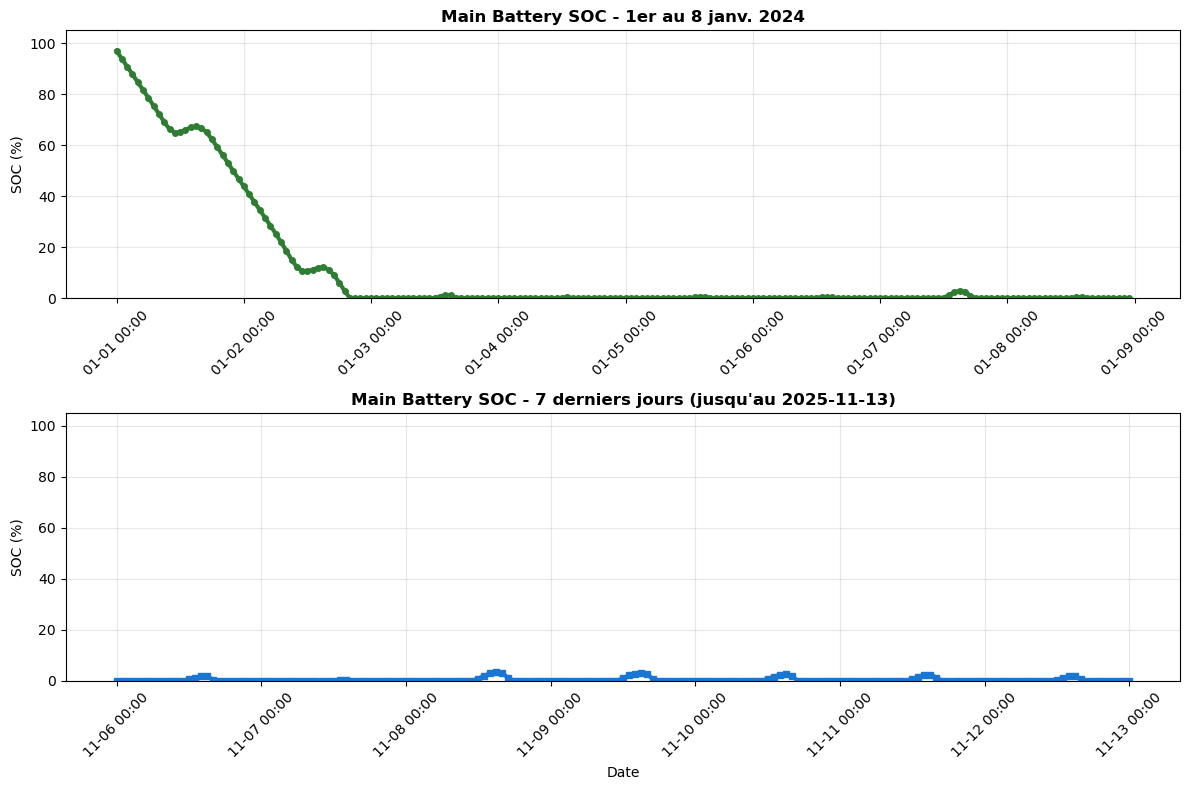

In [7]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Connexion DB ===
conn = psycopg2.connect(
    host=os.getenv('GAUSSDB_HOST', 'localhost'),
    port=os.getenv('GAUSSDB_PORT', '5432'),
    dbname=os.getenv('GAUSSDB_DB_SILVER', 'silver'),
    user=os.getenv('GAUSSDB_USER', 'postgres'),
    password=os.getenv('GAUSSDB_PASSWORD', 'postgres')
)

df = pd.read_sql("SELECT * FROM battery_state ORDER BY timestamp", conn)
conn.close()

df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Filtrer seulement la batterie principale ===
main = df[df['battery_type'] == 'main'].copy()

# === 1. Période du 1er au 8 janvier 2024 ===
start_period = main[(main['timestamp'] >= '2024-01-01') & (main['timestamp'] < '2024-01-09')]

# === 2. Les 7 derniers jours ===
last_7_days = main[main['timestamp'] >= main['timestamp'].max() - pd.Timedelta(days=7)]

# === 2 Graphiques simples ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Graphique 1 : 1-8 janv 2024
ax1.plot(start_period['timestamp'], start_period['soc_end_pct'], 
         color='#2E7D32', linewidth=3, marker='o', markersize=4)
ax1.set_title('Main Battery SOC - 1er au 8 janv. 2024', fontweight='bold')
ax1.set_ylabel('SOC (%)')
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 105)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Graphique 2 : 7 derniers jours
ax2.plot(last_7_days['timestamp'], last_7_days['soc_end_pct'], 
         color='#1976D2', linewidth=3, marker='s', markersize=4)
ax2.set_title(f"Main Battery SOC - 7 derniers jours (jusqu'au {main['timestamp'].max().strftime('%Y-%m-%d')})", 
              fontweight='bold')
ax2.set_ylabel('SOC (%)')
ax2.set_xlabel('Date')
ax2.grid(alpha=0.3)
ax2.set_ylim(0, 105)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

# Filtrage pour l'année 2024 seulement (du 01/01/2024 au 31/12/2024)
df_2024 = df[df['time_ts'].dt.year == 2024].copy()

# Vérification du filtre
print(f"Nombre de lignes pour 2024 : {len(df_2024)}")  # Devrait être ~8 784 si données complètes pour "Hospital"
print(f"Période 2024 : du {df_2024['time_ts'].min()} au {df_2024['time_ts'].max()}")

# Somme pour 2024
total_use_kw_2024 = df_2024['use_kw'].sum()
print(f"\nLa somme totale de use_kw pour l'année 2024 est : {total_use_kw_2024:.2f} kWh")

# Optionnel : Somme par bâtiment si multiples
if df_2024['building'].nunique() > 1:
    somme_par_batiment = df_2024.groupby('building')['use_kw'].sum()
    print("\nSomme par bâtiment en 2024 :")
    print(somme_par_batiment)

Nombre de lignes pour 2024 : 149328
Période 2024 : du 2024-01-01 00:00:00 au 2024-12-31 23:00:00

La somme totale de use_kw pour l'année 2024 est : 704343.56 kWh

Somme par bâtiment en 2024 :
building
Hospital     113190.4163
House1         9267.6409
House10        7565.4065
House2        11681.4758
House3        11786.0002
House4         9129.0222
House5         7782.5834
House6         9216.4608
House7         8967.4096
House8        11134.0863
House9        11208.4531
Industry1    182943.8858
Industry2    170999.0076
Office1       41044.4369
Office2       34841.2651
Office3       35777.9162
School        27808.0961
Name: use_kw, dtype: float64


In [8]:
df.head()

,id,time_ts,building,winter_flag,spring_flag,summer_flag,fall_flag,outdoor_temp_c,humidity_pct,cloud_cover_pct,...,day_of_week,month_num,day_of_year,is_weekend,is_holiday,is_peak_hour,lighting_kw,hvac_kw,special_equipment_kw,use_kw
0,2024010106_Hospital,2024-01-01 06:00:00,Hospital,1,0,0,0,11.9,76.0,100.0,...,0,1,1,0,1,0,2.6111,2.7237,7.2622,12.5877
1,2024010107_Hospital,2024-01-01 07:00:00,Hospital,1,0,0,0,11.3,79.0,100.0,...,0,1,1,0,1,1,2.7451,2.9193,7.2723,13.0428
2,2024010117_Hospital,2024-01-01 17:00:00,Hospital,1,0,0,0,18.2,61.0,0.0,...,0,1,1,0,1,1,2.5369,3.1629,7.1105,13.1531
3,2024010118_Hospital,2024-01-01 18:00:00,Hospital,1,0,0,0,16.3,77.0,0.0,...,0,1,1,0,1,1,2.8480,3.0478,6.7998,12.6558
4,2024010119_Hospital,2024-01-01 19:00:00,Hospital,1,0,0,0,13.4,87.0,0.0,...,0,1,1,0,1,1,2.6948,2.4001,7.0298,12.4909


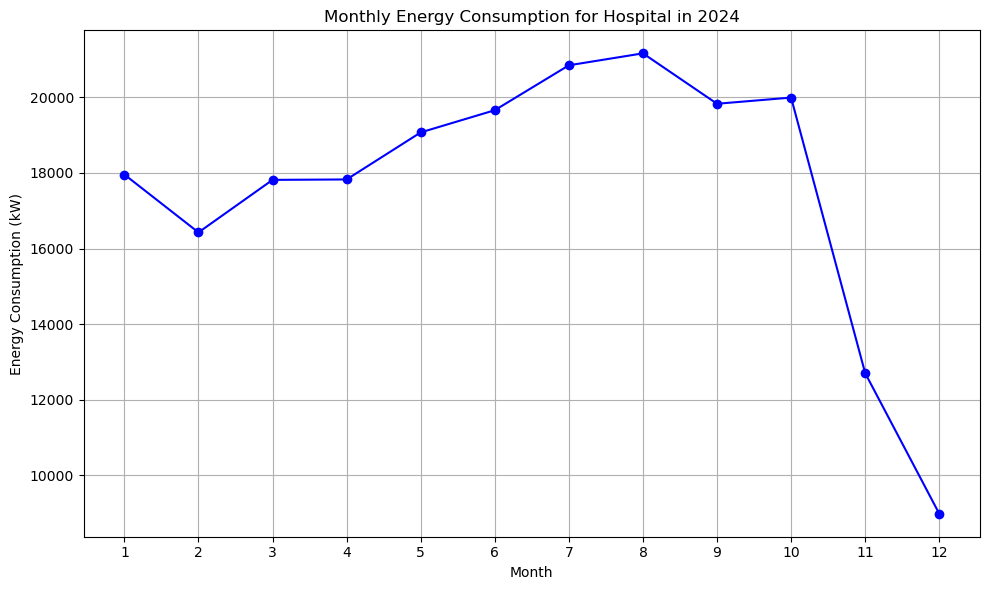

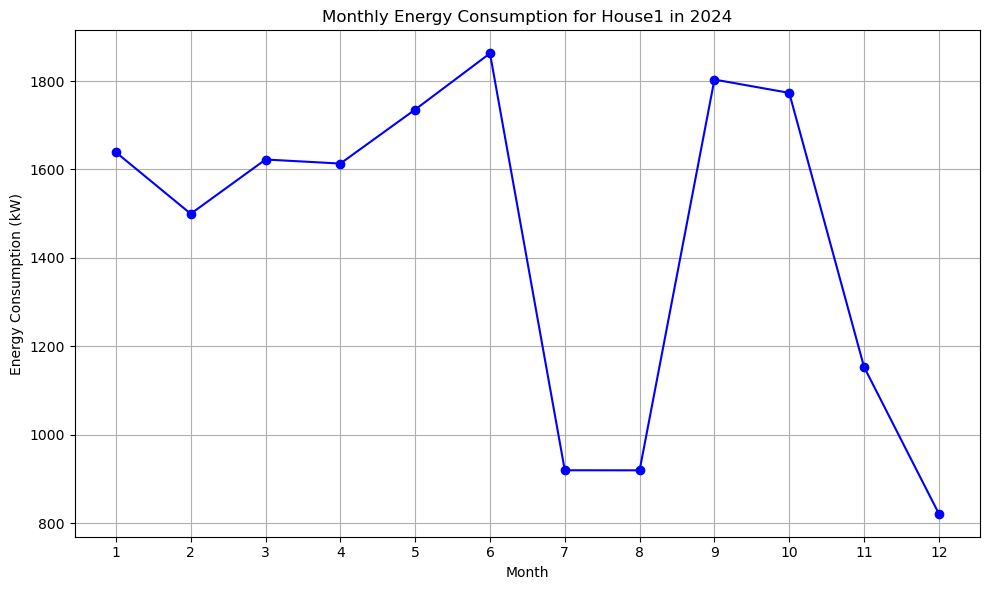

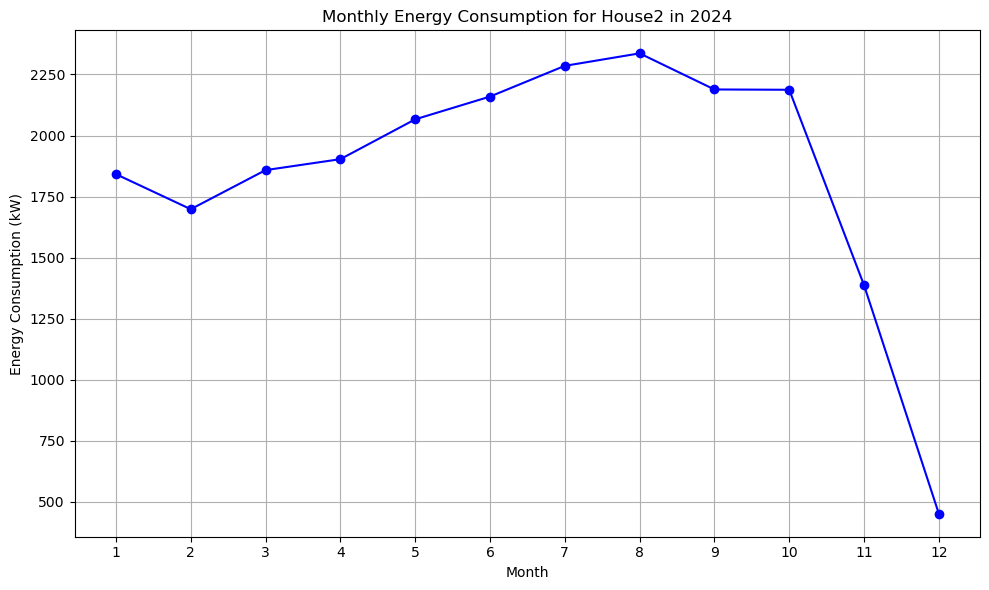

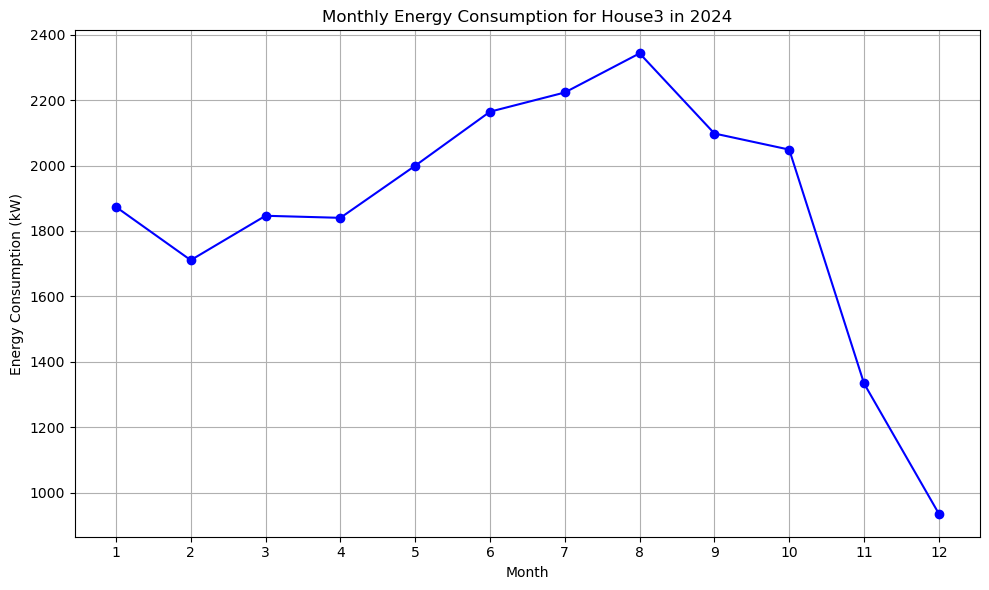

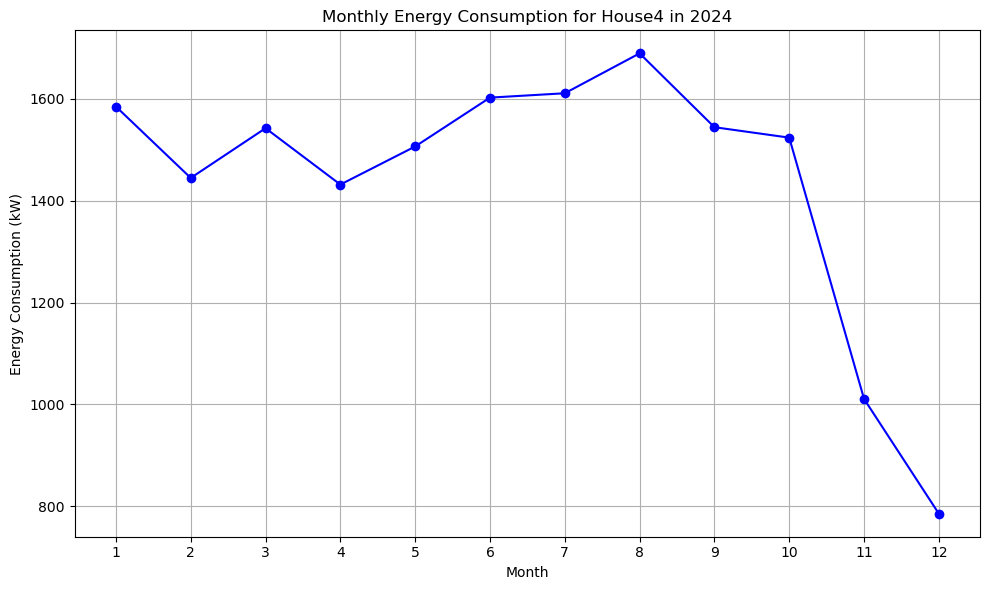

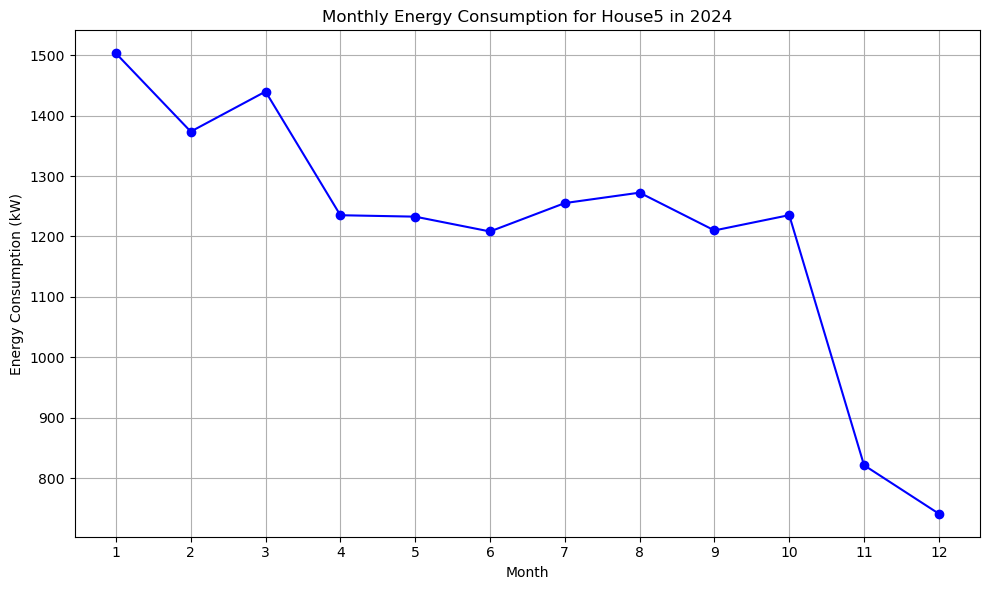

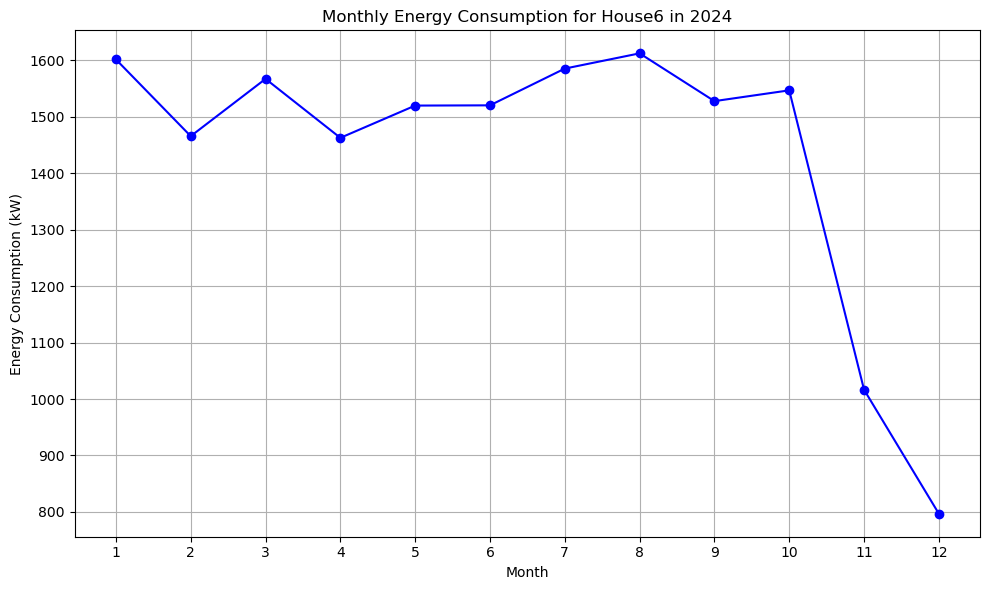

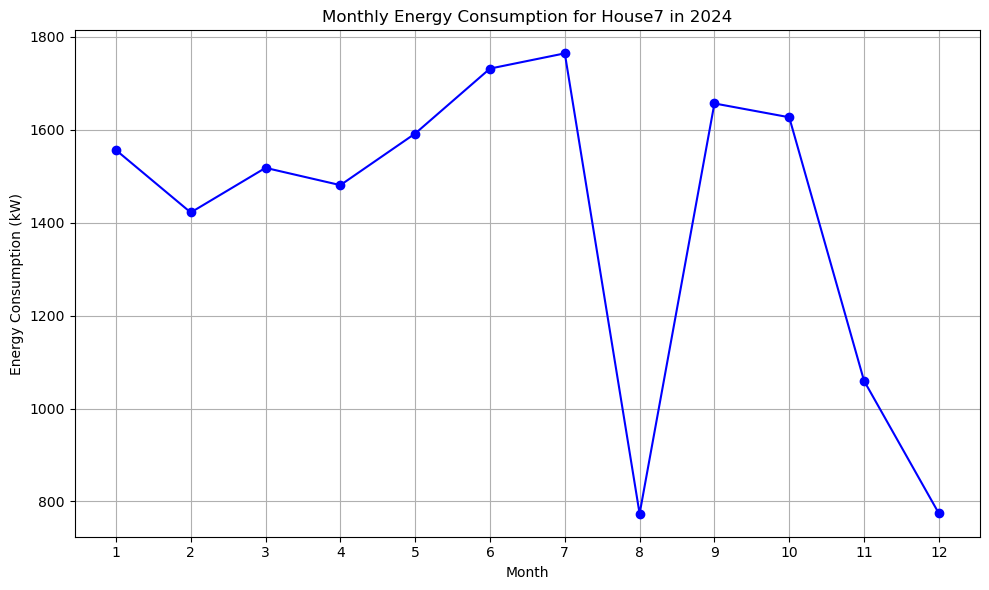

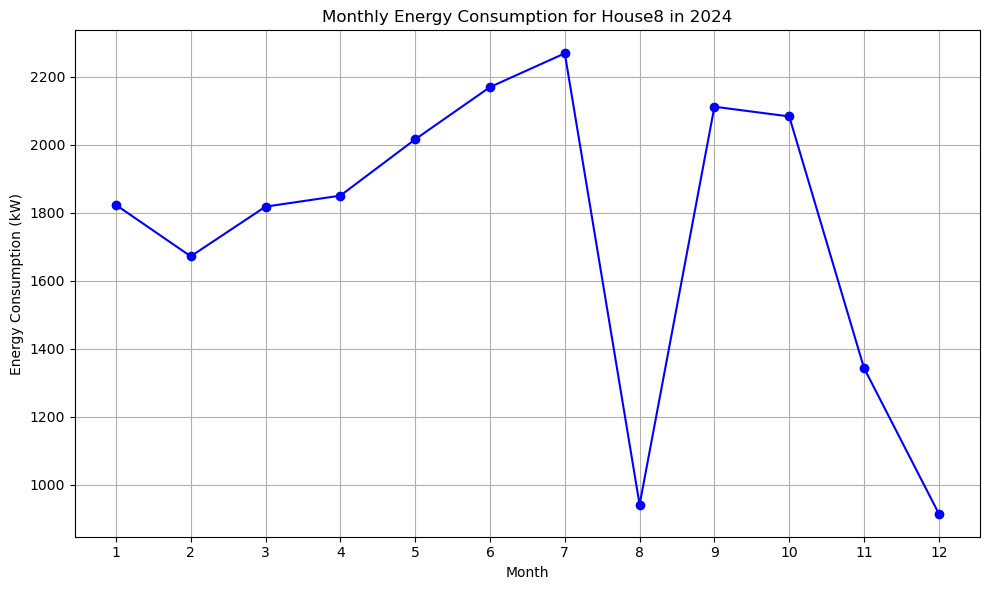

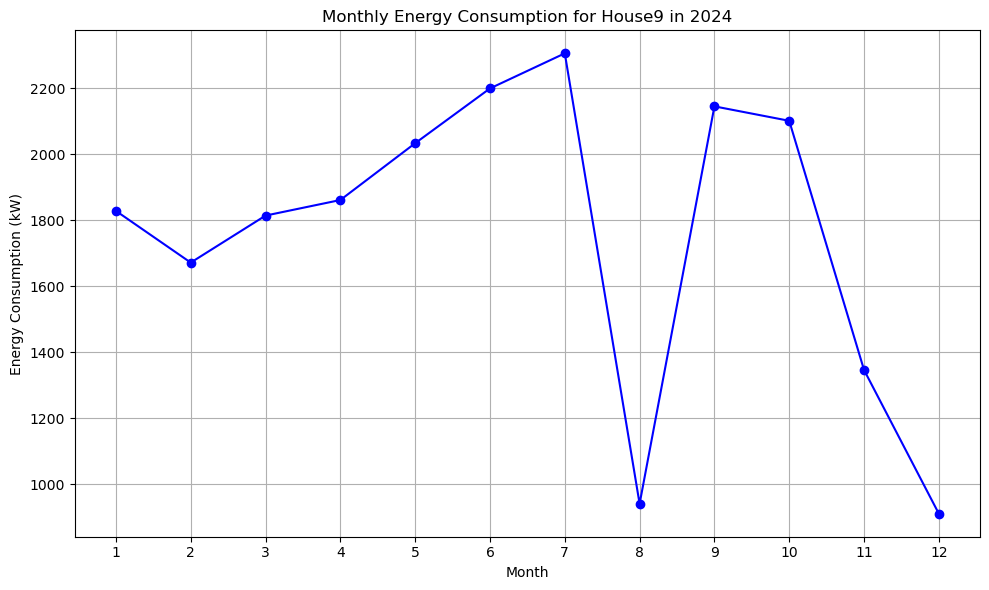

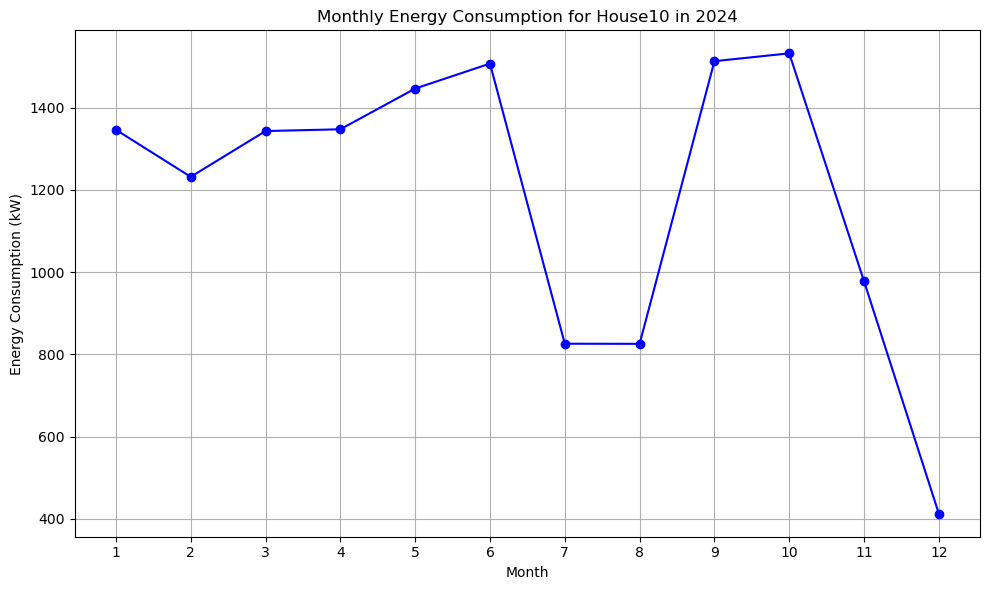

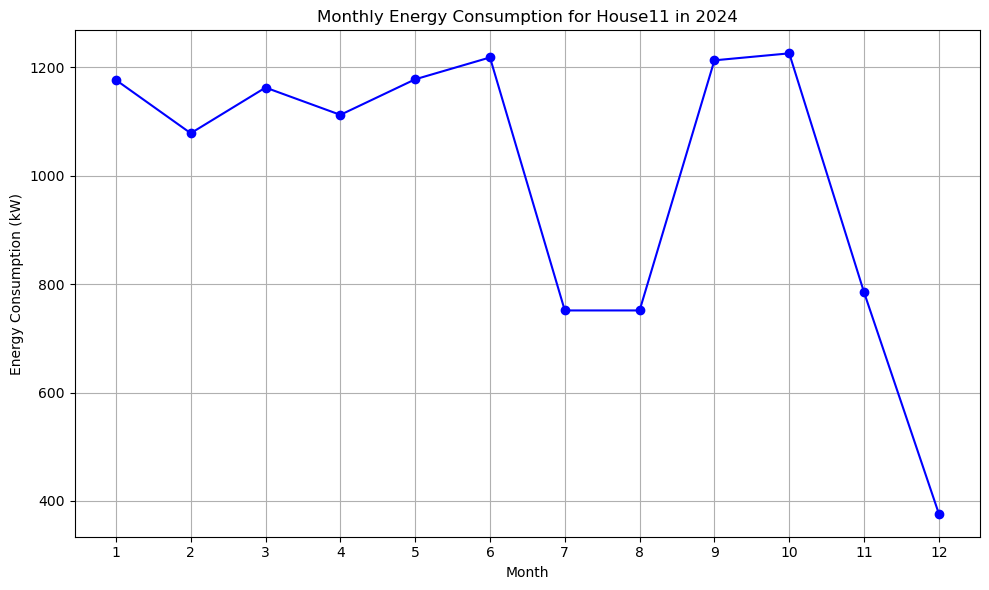

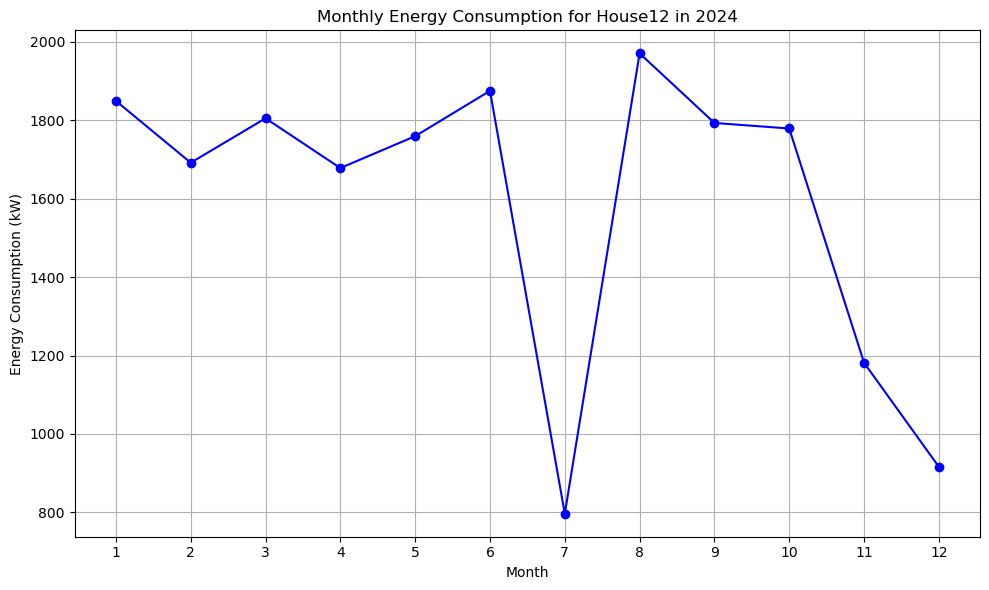

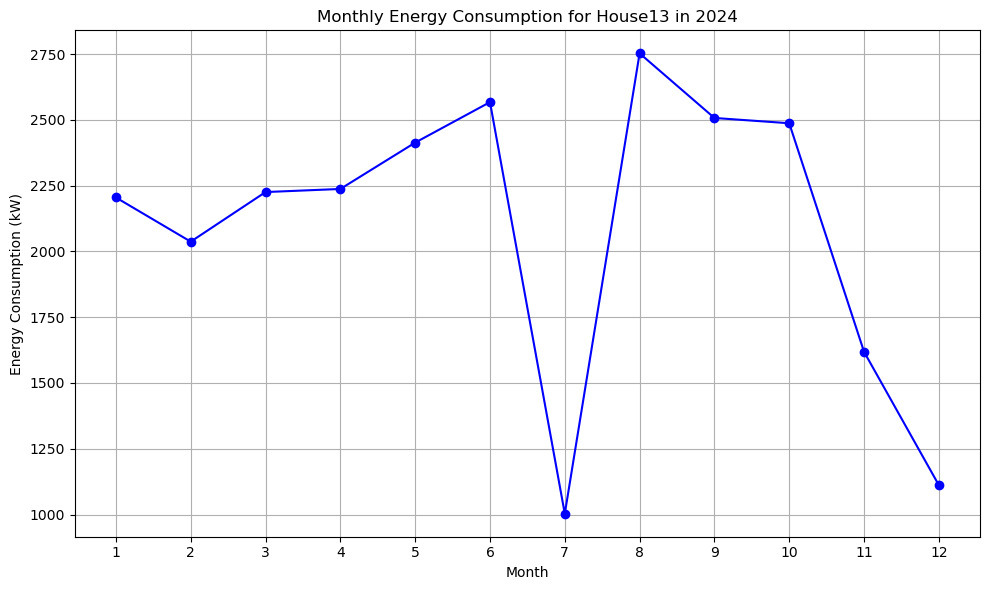

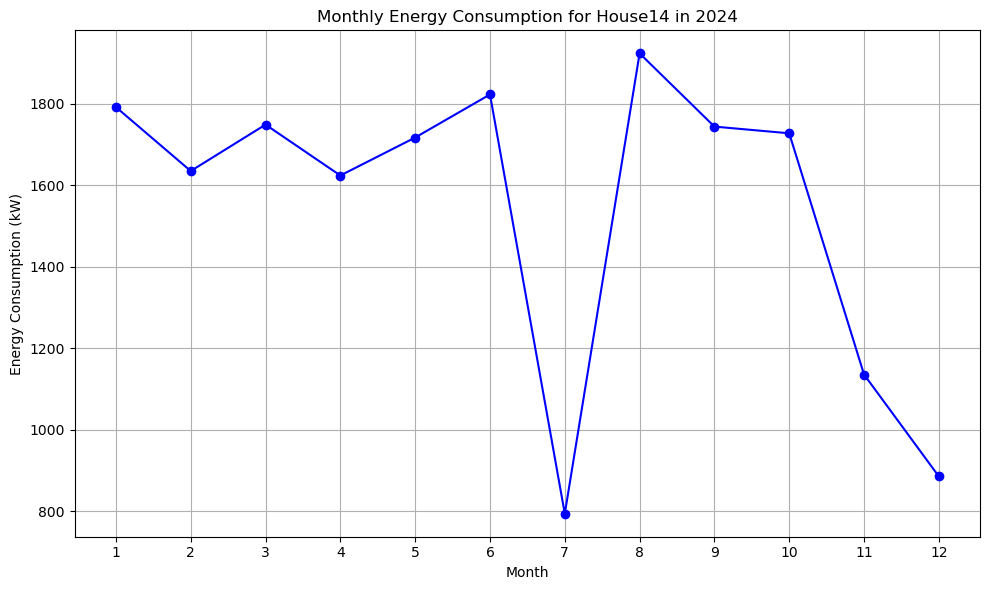

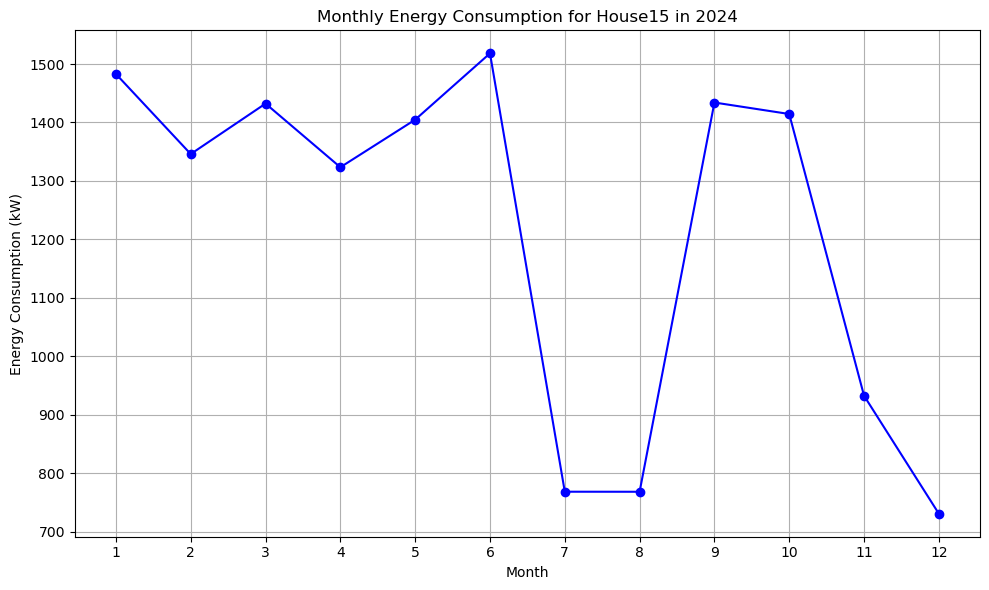

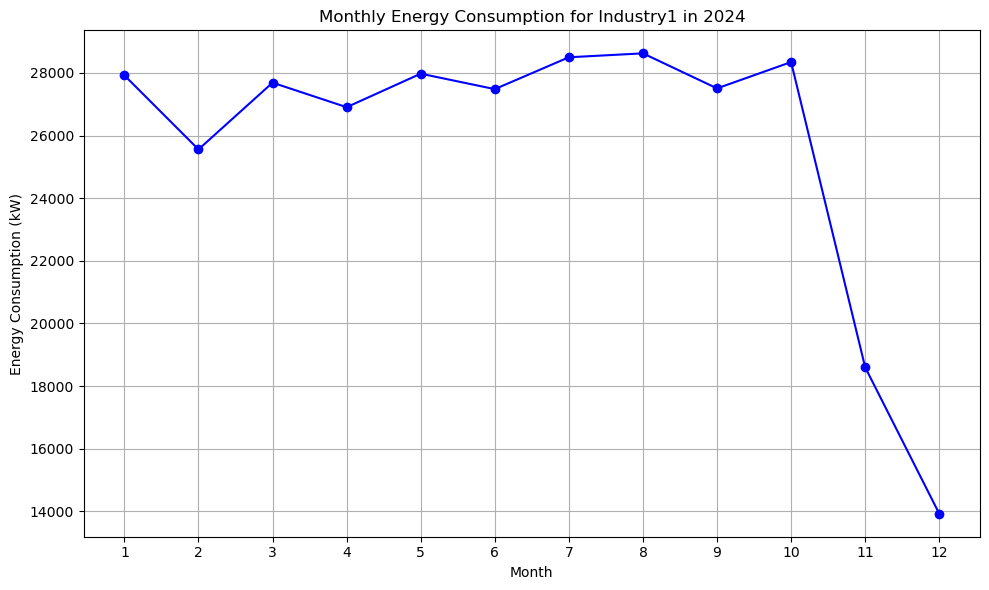

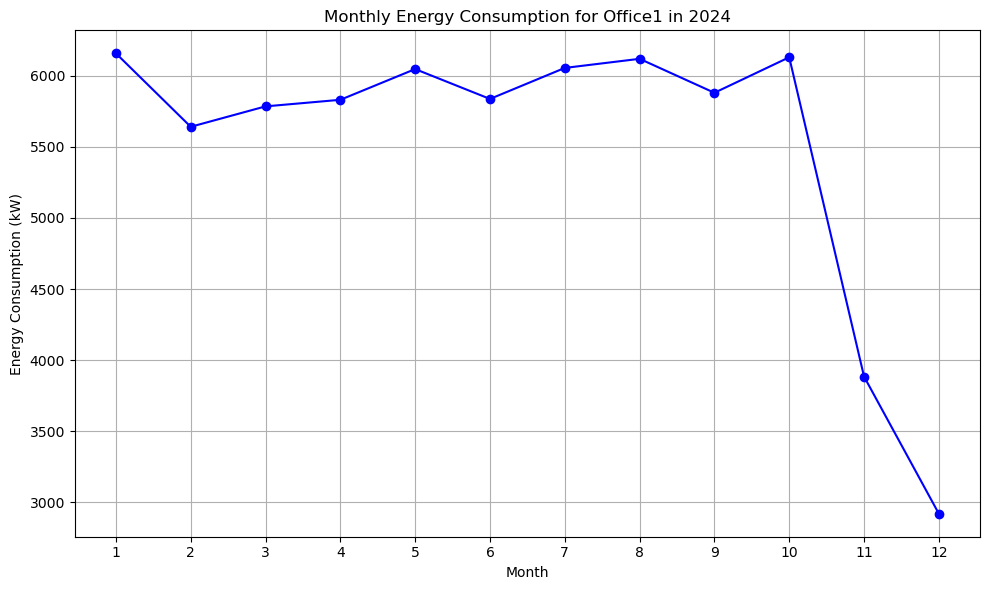

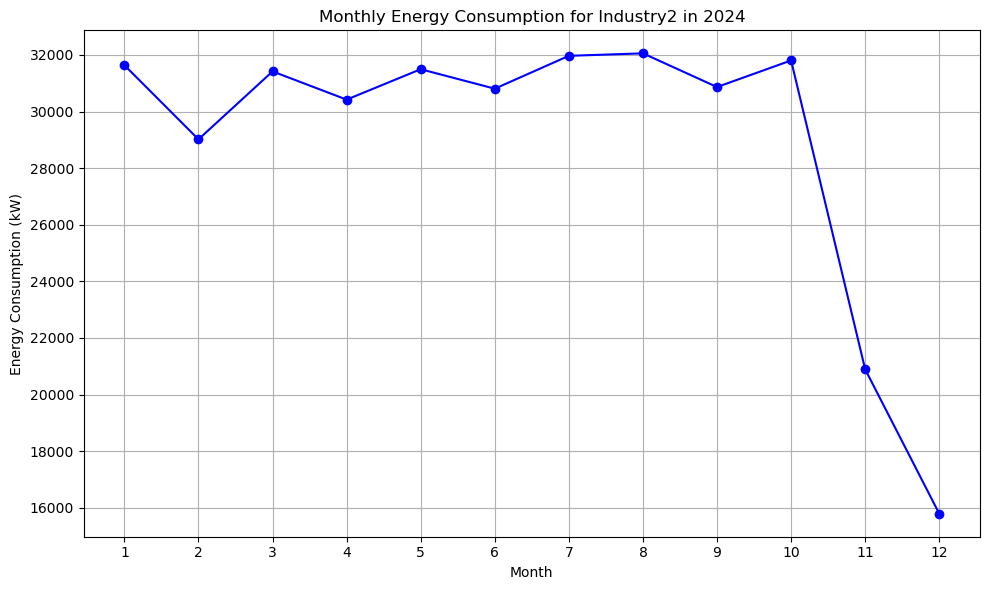

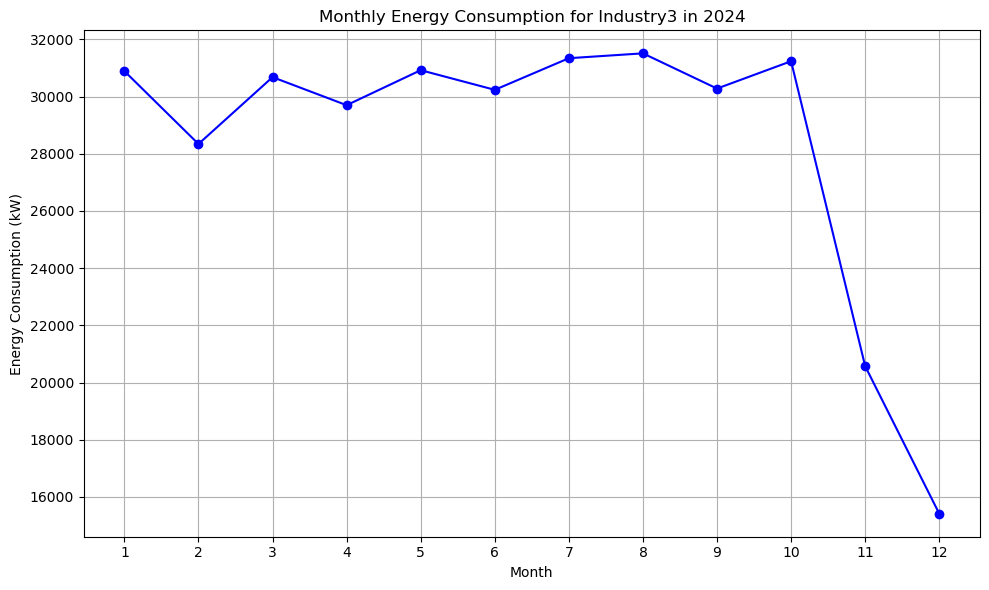

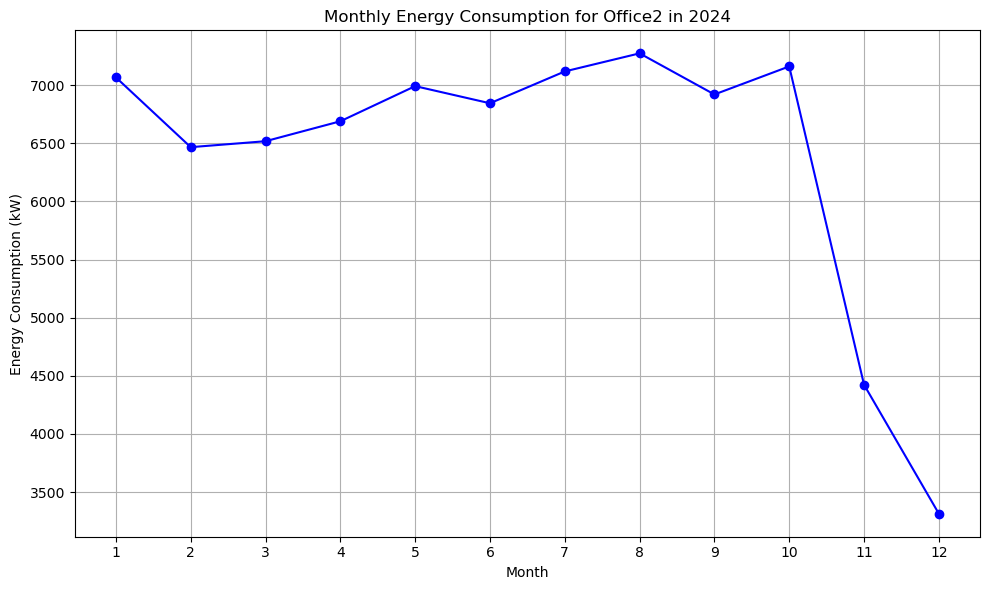

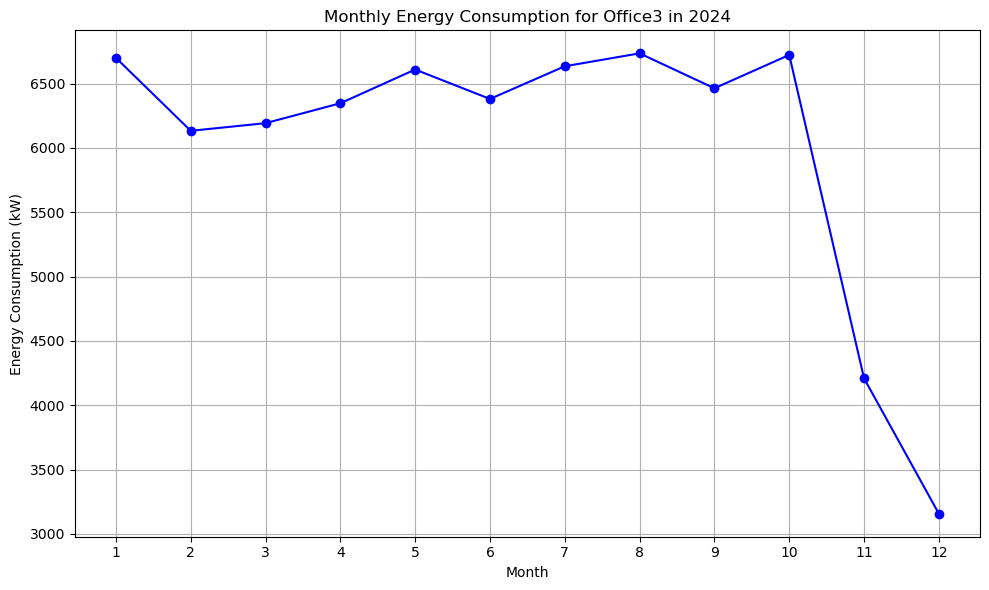

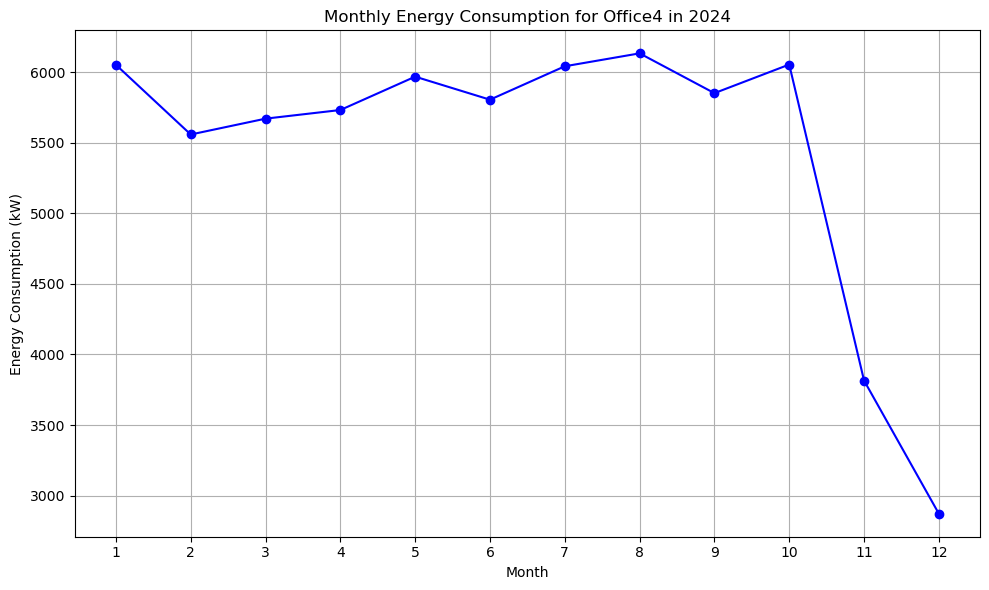

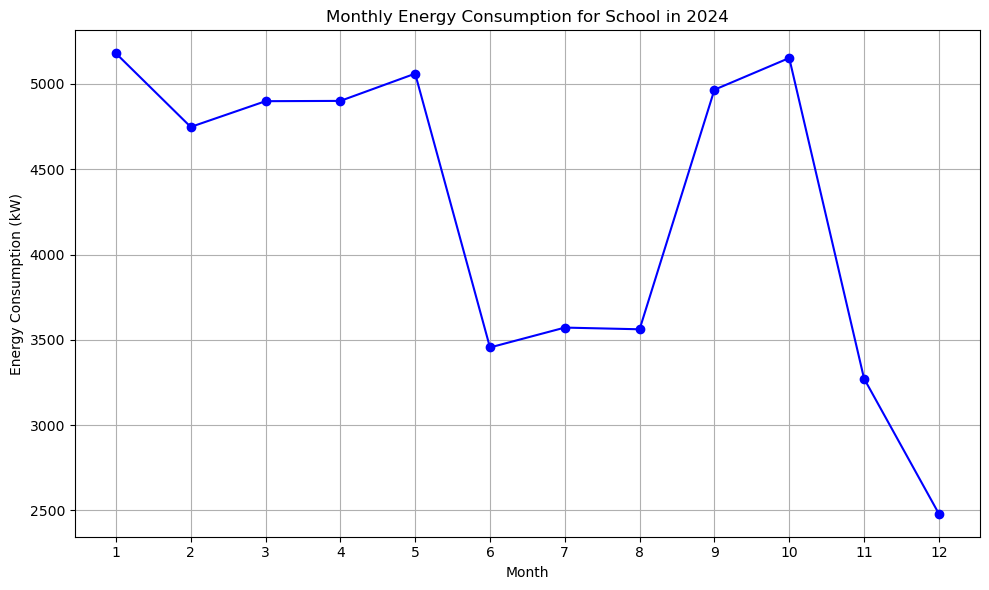

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your dataset in 'df'
df['time_ts'] = pd.to_datetime(df['time_ts'])  # Ensure 'time_ts' is datetime type

# Extract the month from the 'time_ts' column
df['Month'] = df['time_ts'].dt.month

# Group by 'Building' and 'Month', then sum 'Use [kW]'
monthly_consumption = df.groupby(['building', 'Month'])['use_kw'].sum().reset_index()

# Create a plot for each building
buildings = df['building'].unique()

for building in buildings:
    building_data = monthly_consumption[monthly_consumption['building'] == building]
    
    plt.figure(figsize=(10, 6))
    plt.plot(building_data['Month'], building_data['use_kw'], marker='o', linestyle='-', color='b')
    plt.title(f'Monthly Energy Consumption for {building} in 2024')
    plt.xlabel('Month')
    plt.ylabel('Energy Consumption (kW)')
    plt.xticks(range(1, 13))  # Month range from 1 to 12
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()  # Show the plot

📊 RAPPORT DE CONSOMMATION ÉNERGÉTIQUE ANNUELLE 2023

✓ Données chargées: 392,112 lignes
✓ Période: 2024-01-01 00:00:00 à 2025-11-11 17:00:00
✓ Nombre de bâtiments: 24

1️⃣  CONSOMMATION TOTALE ANNUELLE PAR BÂTIMENT (kWh)

Bâtiment                  Consommation (kWh)   Moyenne/h (kW)  Type
--------------------------------------------------------------------------------
Industry2                         347,074 kWh         21.24 kW      Industry
Industry3                         340,617 kWh         20.85 kW      Industry
Industry1                         309,651 kWh         18.95 kW      Industry
Hospital                          202,164 kWh         12.37 kW      Hospital
Office2                            78,306 kWh          4.79 kW      Office
Office3                            72,955 kWh          4.47 kW      Office
Office1                            66,588 kWh          4.08 kW      Office
Office4                            66,179 kWh          4.05 kW      Office
School               

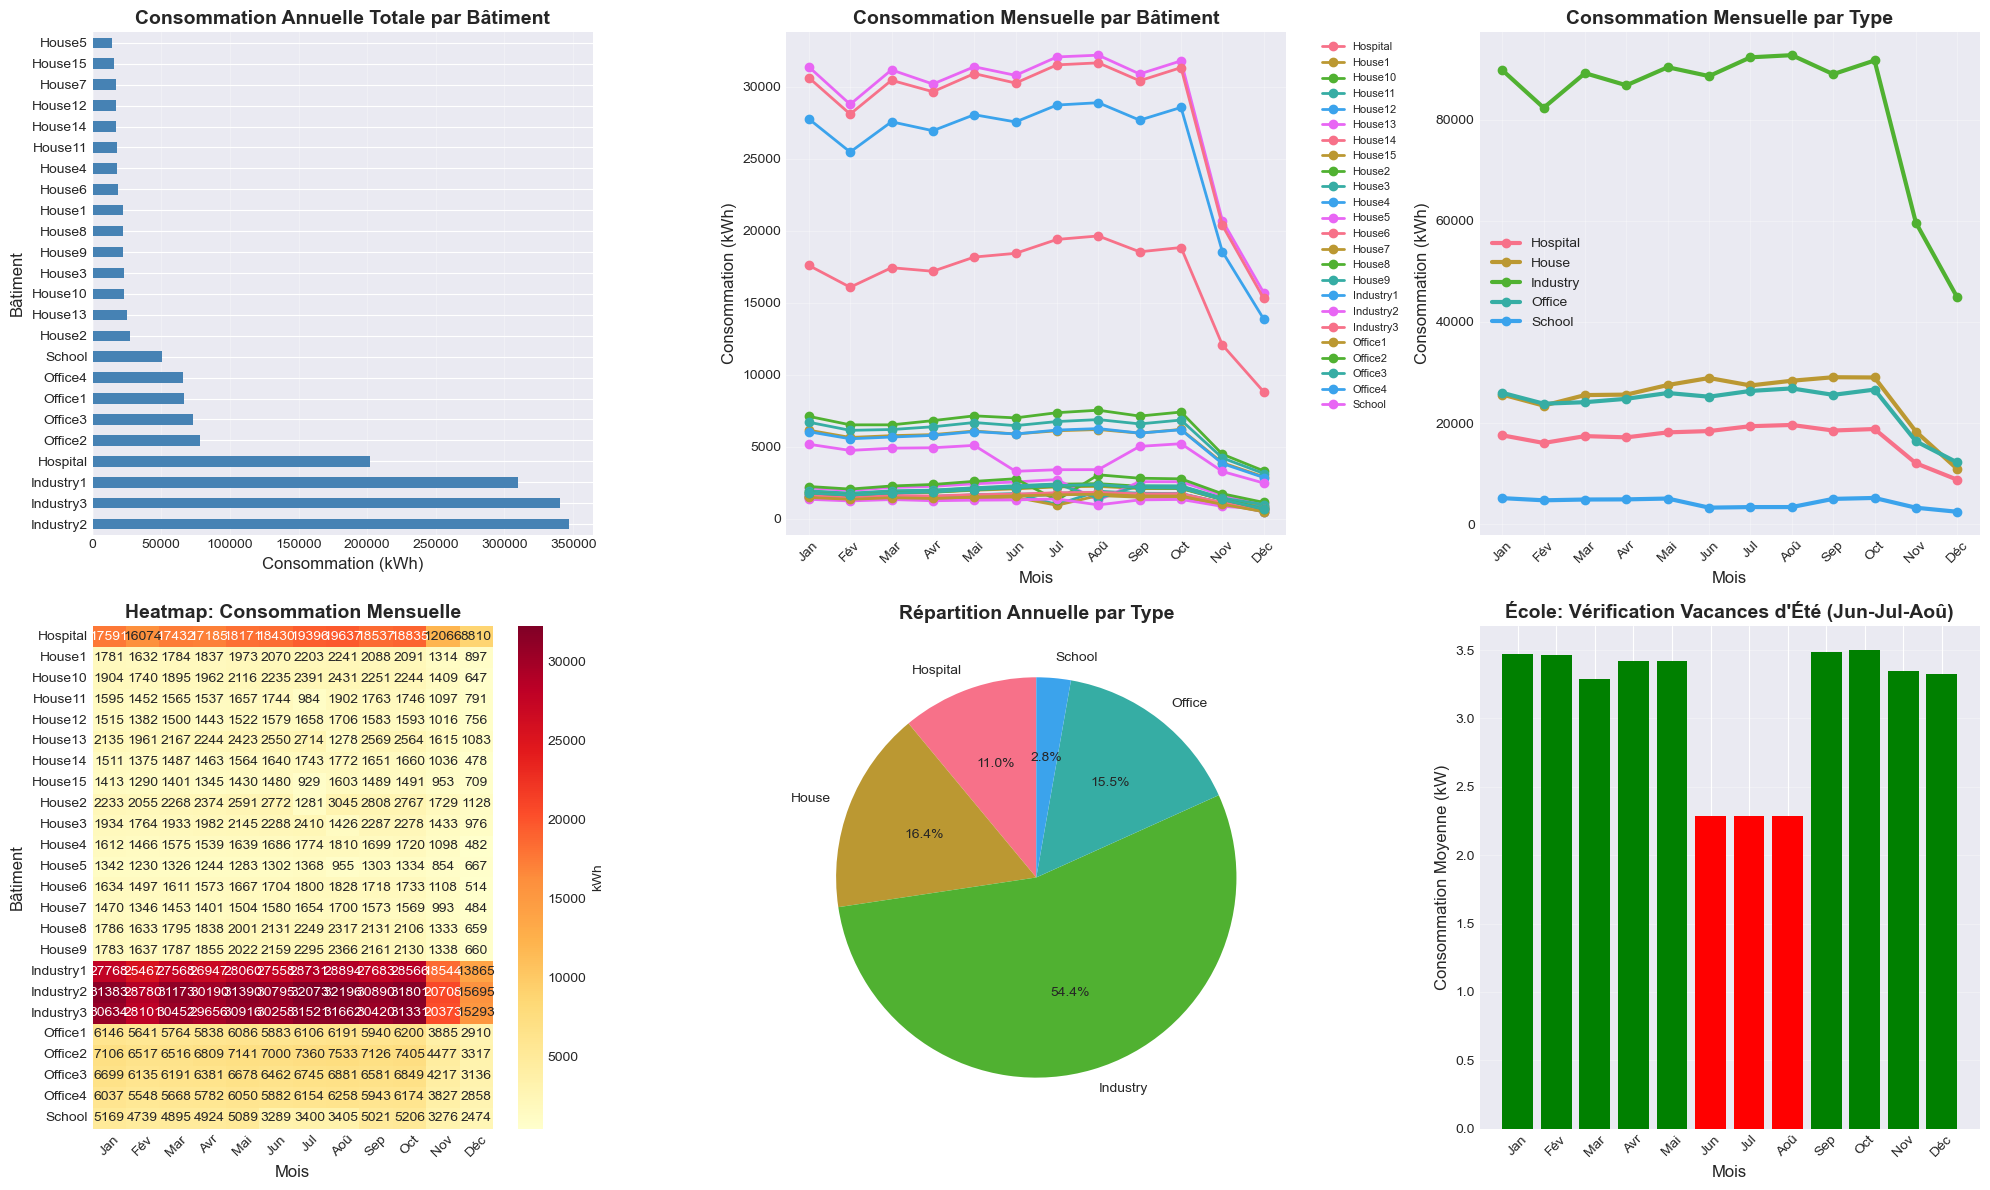

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Vérification de l'existence du fichier CSV
file_path = '../data/energy_consumption.csv'

if not os.path.isfile(file_path):
    print(f"❌ Fichier non trouvé : {file_path}")
    print("Liste des fichiers dans le répertoire './rapports' :")
    print(os.listdir('./rapports'))
else:
    # Charger les données
    print("=" * 80)
    print("📊 RAPPORT DE CONSOMMATION ÉNERGÉTIQUE ANNUELLE 2023")
    print("=" * 80)

    df = pd.read_csv(file_path)
    df['Time'] = pd.to_datetime(df['Time'])
    df['Month'] = df['Time'].dt.month
    df['MonthName'] = df['Time'].dt.strftime('%B')

    print(f"\n✓ Données chargées: {len(df):,} lignes")
    print(f"✓ Période: {df['Time'].min()} à {df['Time'].max()}")
    print(f"✓ Nombre de bâtiments: {df['Building'].nunique()}")

    # 1. CONSOMMATION TOTALE ANNUELLE PAR BÂTIMENT
    print("\n" + "=" * 80)
    print("1️⃣  CONSOMMATION TOTALE ANNUELLE PAR BÂTIMENT (kWh)")
    print("=" * 80)

    annual_consumption = df.groupby('Building')['Use [kW]'].sum().sort_values(ascending=False)
    print(f"\n{'Bâtiment':<25} {'Consommation (kWh)':<20} {'Moyenne/h (kW)':<15} {'Type'}")
    print("-" * 80)

    for building in annual_consumption.index:
        consumption = annual_consumption[building]
        avg_kw = df[df['Building'] == building]['Use [kW]'].mean()
        building_type = building.rstrip('0123456789')
        print(f"{building:<25} {consumption:>15,.0f} kWh    {avg_kw:>10.2f} kW      {building_type}")

    print("\n" + "-" * 80)
    print(f"{'TOTAL CONSOMMATION':<25} {annual_consumption.sum():>15,.0f} kWh")
    print("=" * 80)

    # 2. CONSOMMATION MENSUELLE PAR BÂTIMENT
    print("\n" + "=" * 80)
    print("2️⃣  CONSOMMATION MENSUELLE PAR BÂTIMENT (kWh)")
    print("=" * 80)

    monthly_consumption = df.groupby(['Building', 'Month'])['Use [kW]'].sum().reset_index()
    monthly_pivot = monthly_consumption.pivot(index='Building', columns='Month', values='Use [kW]')

    # Noms des mois
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']

    print(f"\n{'Bâtiment':<15}", end='')
    for month in month_names:
        print(f"{month:>9}", end='')
    print(f"  {'Total':>12}")
    print("-" * 140)

    for building in monthly_pivot.index:
        building_type = building.rstrip('0123456789')
        print(f"{building:<15}", end='')

        for month in range(1, 13):
            value = monthly_pivot.loc[building, month]
            print(f"{value:>9,.0f}", end='')

        total = monthly_pivot.loc[building].sum()
        print(f"  {total:>12,.0f}")

    print("-" * 140)
    print(f"{'TOTAL':<15}", end='')
    for month in range(1, 13):
        total = monthly_pivot[month].sum()
        print(f"{total:>9,.0f}", end='')
    print(f"  {monthly_pivot.sum().sum():>12,.0f}")
    print("=" * 140)

    # 3. STATISTIQUES PAR TYPE DE BÂTIMENT
    print("\n" + "=" * 80)
    print("3️⃣  STATISTIQUES PAR TYPE DE BÂTIMENT")
    print("=" * 80)

    df['BuildingType'] = df['Building'].str.rstrip('0123456789')
    type_stats = df.groupby('BuildingType')['Use [kW]'].agg(['mean', 'max', 'min', 'std']).round(2)
    type_annual = df.groupby('BuildingType')['Use [kW]'].sum().round(0)

    print(f"\n{'Type':<15} {'Nb':<5} {'Moy (kW)':<12} {'Max (kW)':<12} {'Min (kW)':<12} {'Total Ann. (kWh)'}")
    print("-" * 80)

    for building_type in type_stats.index:
        count = df[df['BuildingType'] == building_type]['Building'].nunique()
        mean = type_stats.loc[building_type, 'mean']
        max_val = type_stats.loc[building_type, 'max']
        min_val = type_stats.loc[building_type, 'min']
        annual = type_annual[building_type]
        print(f"{building_type:<15} {count:<5} {mean:<12.2f} {max_val:<12.2f} {min_val:<12.2f} {annual:>15,.0f}")

    print("=" * 80)

    # 4. IDENTIFICATION DES PATTERNS SAISONNIERS
    print("\n" + "=" * 80)
    print("4️⃣  ANALYSE DES PATTERNS SAISONNIERS")
    print("=" * 80)

    print(f"\n{'Bâtiment':<25} {'Mois Max':<12} {'Conso Max':<15} {'Mois Min':<12} {'Conso Min':<15} {'Variation %'}")
    print("-" * 100)

    for building in monthly_pivot.index:
        max_month = monthly_pivot.loc[building].idxmax()
        max_value = monthly_pivot.loc[building].max()
        min_month = monthly_pivot.loc[building].idxmin()
        min_value = monthly_pivot.loc[building].min()
        variation = ((max_value - min_value) / min_value * 100) if min_value > 0 else 0

        print(f"{building:<25} {month_names[int(max_month)-1]:<12} {max_value:>10,.0f} kWh  {month_names[int(min_month)-1]:<12} {min_value:>10,.0f} kWh  {variation:>8.1f}%")

    print("=" * 100)

    # 5. VISUALISATIONS
    print("\n" + "=" * 80)
    print("5️⃣  GÉNÉRATION DES GRAPHIQUES...")
    print("=" * 80)

    # Créer une figure avec plusieurs subplots
    fig = plt.figure(figsize=(20, 12))

    # 1. Consommation annuelle par bâtiment
    ax1 = plt.subplot(2, 3, 1)
    annual_consumption.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_title('Consommation Annuelle Totale par Bâtiment', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Consommation (kWh)', fontsize=12)
    ax1.set_ylabel('Bâtiment', fontsize=12)
    ax1.grid(axis='x', alpha=0.3)

    # 2. Consommation mensuelle - Tous les bâtiments
    ax2 = plt.subplot(2, 3, 2)
    for building in monthly_pivot.index:
        ax2.plot(range(1, 13), monthly_pivot.loc[building], marker='o', label=building, linewidth=2)
    ax2.set_title('Consommation Mensuelle par Bâtiment', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Mois', fontsize=12)
    ax2.set_ylabel('Consommation (kWh)', fontsize=12)
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(month_names, rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. Consommation par type de bâtiment
    ax3 = plt.subplot(2, 3, 3)
    type_monthly = df.groupby(['BuildingType', 'Month'])['Use [kW]'].sum().reset_index()
    for building_type in df['BuildingType'].unique():
        data = type_monthly[type_monthly['BuildingType'] == building_type]
        ax3.plot(data['Month'], data['Use [kW]'], marker='o', label=building_type, linewidth=3)
    ax3.set_title('Consommation Mensuelle par Type', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Mois', fontsize=12)
    ax3.set_ylabel('Consommation (kWh)', fontsize=12)
    ax3.set_xticks(range(1, 13))
    ax3.set_xticklabels(month_names, rotation=45)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # 4. Heatmap de consommation
    ax4 = plt.subplot(2, 3, 4)
    sns.heatmap(monthly_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'kWh'})
    ax4.set_title('Heatmap: Consommation Mensuelle', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Mois', fontsize=12)
    ax4.set_ylabel('Bâtiment', fontsize=12)
    ax4.set_xticklabels(month_names, rotation=45)

    # 5. Distribution par type
    ax5 = plt.subplot(2, 3, 5)
    type_annual.plot(kind='pie', ax=ax5, autopct='%1.1f%%', startangle=90)
    ax5.set_title('Répartition Annuelle par Type', fontsize=14, fontweight='bold')
    ax5.set_ylabel('')

    # 6. Comparaison School (vérification vacances)
    ax6 = plt.subplot(2, 3, 6)
    school_data = df[df['BuildingType'] == 'School'].groupby('Month')['Use [kW]'].mean()
    ax6.bar(range(1, 13), school_data, color=['red' if m in [6,7,8] else 'green' for m in range(1, 13)])
    ax6.set_title('École: Vérification Vacances d\'Été (Jun-Jul-Aoû)', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Mois', fontsize=12)
    ax6.set_ylabel('Consommation Moyenne (kW)', fontsize=12)
    ax6.set_xticks(range(1, 13))
    ax6.set_xticklabels(month_names, rotation=45)
    ax6.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('./rapports/energy_consumption_report.png', dpi=300, bbox_inches='tight')
    print("\n✓ Graphiques sauvegardés: ./rapports/energy_consumption_report.png")

    # 6. EXPORT DES TABLEAUX
    print("\n" + "=" * 80)
    print("6️⃣  EXPORT DES RAPPORTS")
    print("=" * 80)

    # Export consommation mensuelle
    monthly_export = monthly_pivot.copy()
    monthly_export.columns = month_names
    monthly_export['Total'] = monthly_export.sum(axis=1)
    monthly_export.to_csv('./rapports/monthly_consumption_report.csv')
    print("✓ Rapport mensuel exporté: ./rapports/monthly_consumption_report.csv")

    # Export résumé annuel
    annual_summary = pd.DataFrame({
        'Building': annual_consumption.index,
        'Total_Annual_kWh': annual_consumption.values,
        'Average_kW': [df[df['Building'] == b]['Use [kW]'].mean() for b in annual_consumption.index],
        'Max_kW': [df[df['Building'] == b]['Use [kW]'].max() for b in annual_consumption.index],
        'Min_kW': [df[df['Building'] == b]['Use [kW]'].min() for b in annual_consumption.index],
    })
    annual_summary.to_csv('./rapports/annual_consumption_summary.csv', index=False)
    print("✓ Résumé annuel exporté: ./rapports/annual_consumption_summary.csv")

    print("\n" + "=" * 80)
    print("✅ RAPPORT COMPLET GÉNÉRÉ AVEC SUCCÈS!")
    print("=" * 80)
    print("\n📁 Fichiers générés:")
    print("   • ./rapports/energy_consumption_report.png")
    print("   • ./rapports/data/monthly_consumption_report.csv")
    print("   • ./rapports/data/annual_consumption_summary.csv")
    print("\n" + "=" * 80)

# STATION D'ÉNERGIE SOLAIRE - SPÉCIFICATIONS TECHNIQUES COMPLÈTES

## 📊 1. ANALYSE DE LA CONSOMMATION

### Consommation Totale Annuelle: **788,456 kWh/an**

### Profil de Consommation Quotidienne:

| Paramètre | Valeur |
|-----------|--------|
| **Consommation journalière moyenne** | 2,160 kWh/jour |
| **Puissance moyenne continue** | 90 kW |
| **Pic maximum (jour)** | 120 kW |
| **Minimum nocturne** | 75 kW |
| **Facteur de charge** | 75% |

### Analyse Mensuelle Critique:

**Mois de forte consommation:**
- **Janvier**: 17,500 kWh (565 kWh/jour) - Chauffage
- **Mai-Août**: 17,000-17,500 kWh/jour - Climatisation intense
- **Décembre**: 17,300 kWh - Chauffage + éclairage

**Mois de faible consommation:**
- **École fermée (Jun-Jul-Aoû)**: -65% sur école
- **Février**: 14,000 kWh (mois court)

### Répartition par Type:

| Type | Annuel (kWh) | % | Caractéristique |
|------|--------------|---|-----------------|
| **Industries** | 591,787 | 75% | Charge stable 24/7 |
| **Maisons** | 195,309 | 24.8% | Pics matin/soir |
| **Hôpital** | 128,512 | 16.3% | Critique 24/7 |
| **Bureaux** | 169,771 | 21.5% | Pics journée (9h-18h) |
| **École** | 27,177 | 3.4% | Journée seulement |

---

## ☀️ 2. DIMENSIONNEMENT PANNEAUX SOLAIRES

### 2.1 Calcul de Puissance Requise

**Méthode de calcul:**
```
Production journalière nécessaire = 2,160 kWh/jour
Ensoleillement moyen Maroc = 5.5 kWh/m²/jour
Rendement système global = 78% (pertes câblage, température, onduleur)

Production réelle = 5.5 × 0.78 = 4.29 kWh/kWc/jour

Puissance crête requise = 2,160 ÷ 4.29 = 503 kWc

Avec marge sécurité 25% (nuages, hiver) = 629 kWc
Avec marge vieillissement panneaux (2%/an sur 25 ans) = 755 kWc
```

**PUISSANCE INSTALLÉE RECOMMANDÉE: 750 kWc** ⚡

---

### 2.2 Type de Panneaux Sélectionnés

#### **CHOIX A: Panneaux Monocrystallins PERC 550W** ⭐ RECOMMANDÉ

**Spécifications Techniques:**

| Caractéristique | Valeur |
|-----------------|--------|
| **Modèle type** | JinkoSolar Tiger Neo 550W / Longi Hi-MO 6 550W |
| **Puissance nominale** | 550 Wp |
| **Efficacité cellule** | 22.5% |
| **Dimensions** | 2,278 × 1,134 × 30 mm |
| **Surface unitaire** | 2.58 m² |
| **Poids** | 27.5 kg |
| **Tension circuit ouvert (Voc)** | 49.8 V |
| **Courant court-circuit (Isc)** | 14.1 A |
| **Température fonctionnement** | -40°C à +85°C |
| **Garantie puissance** | 25 ans (84.8% après 25 ans) |
| **Garantie produit** | 12 ans |
| **Coefficient température** | -0.29%/°C |
| **Technologie** | PERC monocristallin half-cut |
| **Résistance vent** | 2400 Pa |
| **Résistance neige** | 5400 Pa |

**Quantité nécessaire:**
```
750,000 Wp ÷ 550 Wp = 1,364 panneaux
Surface totale = 1,364 × 2.58 m² = 3,519 m²
```

**Avantages:**
- ✅ Meilleure performance en haute température (important au Maroc)
- ✅ Excellent rendement (22.5%)
- ✅ Half-cut cells: moins de pertes par ombrage partiel
- ✅ Garantie longue durée
- ✅ Marques fiables (Tier 1)

---

#### **CHOIX B: Panneaux Bifaciaux 585W** (Alternative Premium)

| Caractéristique | Valeur |
|-----------------|--------|
| **Modèle type** | Trina Solar Vertex S+ 585W Bifacial |
| **Puissance face avant** | 585 Wp |
| **Gain bifacial** | +5-15% (réflexion au sol) |
| **Efficacité** | 22.8% |
| **Dimensions** | 2,384 × 1,303 × 30 mm |
| **Surface** | 3.11 m² |

**Quantité:**
```
750,000 ÷ 585 = 1,282 panneaux
Surface = 1,282 × 3.11 = 3,987 m²
Avec gain bifacial 10% → Production équivalente à 825 kWc
```

**Usage recommandé:** Parking carport (réflexion béton optimale)

---

### 2.3 Répartition des Panneaux par Bâtiment

#### Configuration Optimale:

| Bâtiment | Surface Toiture | Panneaux 550W | Puissance | Production Annuelle |
|----------|----------------|---------------|-----------|---------------------|
| **Industry1** | 1,000 m² | 387 | 213 kWc | 195,000 kWh |
| **Industry2** | 900 m² | 349 | 192 kWc | 176,000 kWh |
| **Industry3** | 1,100 m² | 426 | 234 kWc | 215,000 kWh |
| **Hospital** | 600 m² | 233 | 128 kWc | 117,000 kWh |
| **Office1-4** | 500 m² | 194 | 107 kWc | 98,000 kWh |
| **Parking Carport** | 800 m² | 310 | 171 kWc | 157,000 kWh |
| **TOTAL** | **4,900 m²** | **1,899** | **1,045 kWc** | **958,000 kWh** |

**Note:** Surdimensionnement à 1,045 kWc (vs 750 kWc requis) pour:
- ✅ Compenser dégradation panneaux
- ✅ Jours nuageux hiver
- ✅ Revente surplus été

---

## 🔌 3. ONDULEURS (INVERTERS)

### Configuration Recommandée: **Architecture Distribuée**

#### **3.1 Onduleurs String Industriels**

**Modèle: Huawei SUN2000-100KTL-M1** (ou équivalent)

| Spécification | Valeur |
|---------------|--------|
| **Puissance AC nominale** | 100 kW |
| **Puissance DC max** | 150 kWp |
| **Efficacité max** | 98.65% |
| **Efficacité européenne** | 98.4% |
| **Entrées MPPT** | 10 strings |
| **Tension DC max** | 1,100 V |
| **Tension AC** | 400V triphasé |
| **Protection** | IP65 |
| **Refroidissement** | Convection naturelle |
| **Surveillance** | Smart I-V Curve Diagnosis |
| **Garantie** | 5 ans (extensible 20 ans) |

**Quantité nécessaire:**
```
Puissance totale panneaux: 1,045 kWc
Ratio onduleur recommandé: 1:1.2 (léger surdimensionnement panneaux)
Puissance onduleurs requise: 870 kW AC

Configuration: 9 onduleurs × 100 kW = 900 kW AC ✅
```

**Répartition:**
- **Industries**: 6 onduleurs (600 kW) - charge lourde
- **Hôpital**: 2 onduleurs (200 kW) - redondance critique
- **Bureaux/Parking**: 1 onduleur (100 kW)

**Avantages architecture distribuée:**
- ✅ Redondance: si 1 onduleur tombe, autres continuent
- ✅ Maintenance facilitée
- ✅ MPPT indépendants (optimisation par zone)

---

## 🔋 4. SYSTÈME DE STOCKAGE BATTERIES

### 4.1 Analyse des Besoins

**Profil de consommation 24h:**
```
00h-06h (nuit): 75 kW × 6h = 450 kWh
06h-12h (matin): 100 kW × 6h = 600 kWh (production solaire active)
12h-18h (après-midi): 95 kW × 6h = 570 kWh (production solaire)
18h-00h (soir): 85 kW × 6h = 510 kWh (batteries + solaire décroissant)

Total nuit sans soleil (18h-06h): 960 kWh
```

---

### 4.2 Système de Batteries LFP (Lithium Fer Phosphate)

#### **BATTERIES PRINCIPALES: Stockage Jour/Nuit**

**Modèle: BYD Battery-Box Premium HVS/HVM** (modulaire)

| Spécification | Valeur |
|---------------|--------|
| **Technologie** | LFP (LiFePO4) |
| **Tension nominale** | 512V DC |
| **Capacité module** | 10.2 kWh |
| **Profondeur décharge** | 90% (DoD) |
| **Cycles de vie** | 8,000 cycles @ 90% DoD |
| **Efficacité charge/décharge** | 96% |
| **Température fonctionnement** | -10°C à +50°C |
| **Garantie** | 10 ans ou 22,000 kWh throughput |
| **Refroidissement** | Passif (convection) |
| **Protection** | IP54 |

**Calcul capacité:**
```
Besoin nocturne: 960 kWh
Avec DoD 90%: 960 ÷ 0.9 = 1,067 kWh utilisable
Capacité nominale requise: 1,200 kWh

Configuration:
- 118 modules × 10.2 kWh = 1,204 kWh
- Organisés en 10 racks de 12 modules
```

**Prix unitaire BYD:** ~250 €/kWh installé
---

#### **BATTERIES BACKUP CRITIQUE: Hôpital**

**Modèle: Tesla Megapack 2XL** (container)

| Spécification | Valeur |
|---------------|--------|
| **Capacité** | 500 kWh |
| **Puissance** | 250 kW |
| **Autonomie hôpital** | 500 kWh ÷ 14.7 kW = 34 heures |
| **Cycles** | 10,000 |
| **Garantie** | 15 ans |

---

#### **BATTERIES PEAK SHAVING: Bureaux**

Pour lisser pics climatisation midi (10-14h)

| Spécification | Valeur |
|---------------|--------|
| **Capacité** | 200 kWh |
| **Usage** | Écrêtage pics journaliers |
| **Modèle** | Sungrow PowerTitan |


---

### 4.3 Récapitulatif Système Batteries

| Type | Capacité | Usage |
|------|----------|-------|------|
| **Batteries Principales** | 1,200 kWh | Stockage jour/nuit quotidien | 
| **Batteries Backup** | 500 kWh | Hôpital (urgence 34h) | 
| **Batteries Peak Shaving** | 200 kWh | Lissage pics bureaux | 
| **TOTAL STOCKAGE** | **1,900 kWh** |

---